# Лабораторная работа №4
## Терешин А.В. 20ИВТ3
## Вариант №11

In [42]:
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn as sk
import copy as copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
car_df_original = pd.read_csv('autos.csv', sep = ',', encoding = 'ISO-8859-1')
car_df = copy.copy(car_df_original)
car_df = car_df.drop('dateCrawled', axis = 1)
car_df = car_df.drop('seller', axis = 1)
car_df = car_df.drop('offerType', axis = 1)
car_df = car_df.drop('abtest', axis = 1)
car_df = car_df.drop('monthOfRegistration', axis = 1)
car_df = car_df.drop('dateCreated', axis = 1)
car_df = car_df.drop('nrOfPictures', axis = 1)
car_df = car_df.drop('lastSeen', axis = 1)
car_df = car_df.drop('postalCode', axis = 1)
car_df = car_df.drop('name', axis = 1)
car_df.drop('fuelType', axis = 1, inplace = True)

In [3]:
car_df

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,brand,notRepairedDamage
0,480,NaN,1993,manuell,0,golf,150000,volkswagen,NaN
1,18300,coupe,2011,manuell,190,NaN,125000,audi,ja
2,9800,suv,2004,automatik,163,grand,125000,jeep,NaN
3,1500,kleinwagen,2001,manuell,75,golf,150000,volkswagen,nein
4,3600,kleinwagen,2008,manuell,69,fabia,90000,skoda,nein
...,...,...,...,...,...,...,...,...,...
371523,2200,NaN,2005,NaN,0,NaN,20000,sonstige_autos,NaN
371524,1199,cabrio,2000,automatik,101,fortwo,125000,smart,nein
371525,9200,bus,1996,manuell,102,transporter,150000,volkswagen,nein
371526,3400,kombi,2002,manuell,100,golf,150000,volkswagen,NaN


##  Создаем описание набора данных на русском языке. 

In [4]:
car_df.rename(columns = {'price' : 'цена', 
                           'yearOfRegistration' : 'зарегистрирована',
                           'gearbox' : 'трансмиссия',
                           'kilometer' : 'пробег',
                           'vehicleType' : 'кузов',
                           'notRepairedDamage' : 'битая',
                           'brand' : 'бренд',
                           'model' : 'модель',
                           'powerPS' : 'мощность'},
                           inplace = True)

## Убираем дубликаты и пропущенные значения

In [5]:
car_df = car_df.dropna()
car_df = car_df.drop_duplicates(keep = 'first')

In [6]:
car_df.reset_index(drop = True, inplace = True)

## Заменяем категориальные признаки

In [7]:
car_df['кузов'].value_counts()

limousine     65852
kleinwagen    50078
kombi         46522
bus           22500
cabrio        16845
coupe         13455
suv           10962
andere         1795
Name: кузов, dtype: int64

In [8]:
car_df.loc[car_df.кузов == 'limousine', 'кузов'] = 'лимузин'
car_df.loc[car_df.кузов == 'kleinwagen' , 'кузов'] = 'мини'
car_df.loc[car_df.кузов == 'kombi' , 'кузов'] = 'хэтчбэк'
car_df.loc[car_df.кузов == 'bus' , 'кузов'] = 'автобус'
car_df.loc[car_df.кузов == 'cabrio' , 'кузов'] = 'кабриолет'
car_df.loc[car_df.кузов == 'coupe' , 'кузов'] = 'купе'
car_df.loc[car_df.кузов == 'suv' , 'кузов'] = 'кроссовеер'
car_df.loc[car_df.кузов == 'andere' , 'кузов'] = 'другое'

In [9]:
car_df['трансмиссия'].value_counts()

manuell      173060
automatik     54949
Name: трансмиссия, dtype: int64

In [10]:
car_df.loc[car_df.трансмиссия == 'manuell' , 'трансмиссия'] = 0
car_df.loc[car_df.трансмиссия == 'automatik' , 'трансмиссия'] = 1

In [11]:
car_df.loc[car_df.битая == 'nein' , 'битая'] = 0
car_df.loc[car_df.битая == 'ja' , 'битая'] = 1

In [12]:
car_df.loc[car_df.пробег, 'пробег'] /= 1000
car_df

,цена,кузов,зарегистрирована,трансмиссия,мощность,модель,пробег,бренд,битая
0,1500,мини,2001,0,75,golf,150.0,volkswagen,0
1,3600,мини,2008,0,69,fabia,150.0,skoda,0
2,650,лимузин,1995,0,102,3er,150.0,bmw,1
3,2200,кабриолет,2004,0,109,2_reihe,150.0,peugeot,0
4,0,лимузин,1980,0,50,andere,150.0,volkswagen,0
...,...,...,...,...,...,...,...,...,...
228004,3999,хэтчбэк,2005,0,3,3er,150.0,bmw,0
228005,3200,лимузин,2004,0,225,leon,150.0,seat,1
228006,1199,кабриолет,2000,1,101,fortwo,150.0,smart,0
228007,9200,автобус,1996,0,102,transporter,150.0,volkswagen,0


In [13]:
hash_space = 250
count = 0
for i in car_df['модель']:
   car_df.loc[car_df.index == count, 'модель']  = (hash(i) % hash_space)
   count+=1

In [14]:
hash_space = 50
count = 0
for i in car_df['бренд']:
   car_df.loc[car_df.index == count, 'бренд']  = (hash(i) % hash_space)
   count+=1

In [15]:
df_nonbinary = pd.get_dummies(car_df['кузов'])
car_df.drop('кузов', axis=1, inplace=True)
car_df = pd.concat([df_nonbinary, car_df] , axis=1)

In [16]:
car_df

,автобус,другое,кабриолет,кроссовеер,купе,лимузин,мини,хэтчбэк,цена,зарегистрирована,трансмиссия,мощность,модель,пробег,бренд,битая
0,0,0,0,0,0,0,1,0,1500,2001,0,75,166,150.0,20,0
1,0,0,0,0,0,0,1,0,3600,2008,0,69,4,150.0,6,0
2,0,0,0,0,0,1,0,0,650,1995,0,102,63,150.0,20,1
3,0,0,1,0,0,0,0,0,2200,2004,0,109,116,150.0,10,0
4,0,0,0,0,0,1,0,0,0,1980,0,50,159,150.0,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228004,0,0,0,0,0,0,0,1,3999,2005,0,3,63,150.0,20,0
228005,0,0,0,0,0,1,0,0,3200,2004,0,225,228,150.0,37,1
228006,0,0,1,0,0,0,0,0,1199,2000,1,101,117,150.0,38,0
228007,1,0,0,0,0,0,0,0,9200,1996,0,102,55,150.0,20,0


## Выполняем масштабирование количественных признаков

<AxesSubplot:>

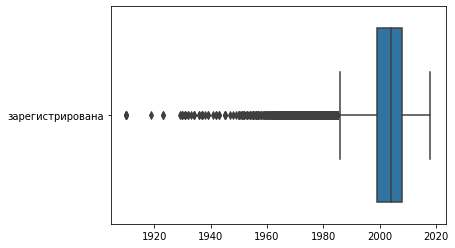

In [17]:
feat_for_scale = pd.DataFrame(car_df['зарегистрирована'])
sns.boxplot(data = feat_for_scale, orient = 'h')

<AxesSubplot:>

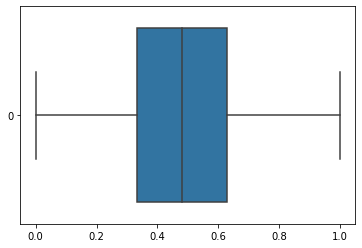

In [18]:
car_df = car_df.loc[car_df.зарегистрирована > 1990]
car_df.reset_index(drop = True, inplace = True)
feat_for_scale = pd.DataFrame(car_df['зарегистрирована'])

scaler = MinMaxScaler()
d = scaler.fit_transform(feat_for_scale)

scaled_feat = pd.DataFrame(d)

sns.boxplot(data = scaled_feat, orient = 'h')

In [19]:
car_df['зарегистрирована'] = scaled_feat

C:\Users\tealvl\AppData\Local\Temp\ipykernel_17784\2146629315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['зарегистрирована'] = scaled_feat


<AxesSubplot:>

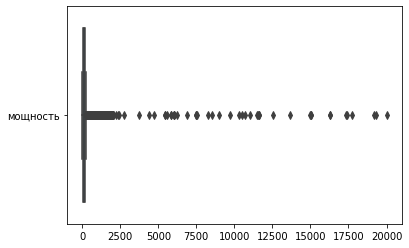

In [20]:
feat_for_scale = pd.DataFrame(car_df['мощность'])
sns.boxplot(data = feat_for_scale, orient = 'h')

<AxesSubplot:>

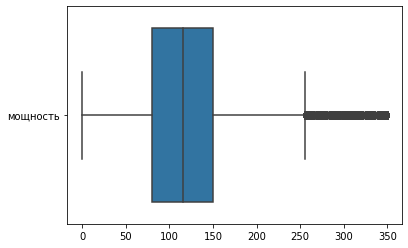

In [21]:
car_df = car_df.loc[car_df.мощность < 350]
car_df.reset_index(drop = True, inplace = True)
feat_for_scale = pd.DataFrame(car_df['мощность'])
sns.boxplot(data = feat_for_scale, orient= 'h')

<AxesSubplot:>

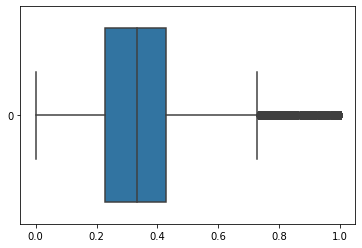

In [22]:
d = scaler.fit_transform(feat_for_scale)

scaled_feat = pd.DataFrame(d)

sns.boxplot(data = scaled_feat, orient = 'h')

In [23]:
car_df['мощность'] = scaled_feat
car_df

,автобус,другое,кабриолет,кроссовеер,купе,лимузин,мини,хэтчбэк,цена,зарегистрирована,трансмиссия,мощность,модель,пробег,бренд,битая
0,0,0,0,0,0,0,1,0,1500,0.370370,0,0.214900,166,150.0,20,0
1,0,0,0,0,0,0,1,0,3600,0.629630,0,0.197708,4,150.0,6,0
2,0,0,0,0,0,1,0,0,650,0.148148,0,0.292264,63,150.0,20,1
3,0,0,1,0,0,0,0,0,2200,0.481481,0,0.312321,116,150.0,10,0
4,0,0,0,0,0,1,0,0,2000,0.481481,0,0.300860,244,150.0,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218991,0,0,0,0,0,0,0,1,3999,0.518519,0,0.008596,63,150.0,20,0
218992,0,0,0,0,0,1,0,0,3200,0.481481,0,0.644699,228,150.0,37,1
218993,0,0,1,0,0,0,0,0,1199,0.333333,1,0.289398,117,150.0,38,0
218994,1,0,0,0,0,0,0,0,9200,0.185185,0,0.292264,55,150.0,20,0


<AxesSubplot:>

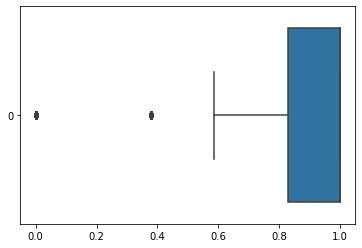

In [24]:
feat_for_scale = pd.DataFrame(car_df['пробег'])
d = scaler.fit_transform(feat_for_scale)
scaled_feat = pd.DataFrame(d)
sns.boxplot(data = scaled_feat, orient = 'h')

In [25]:
car_df['пробег'] = scaled_feat
car_df

,автобус,другое,кабриолет,кроссовеер,купе,лимузин,мини,хэтчбэк,цена,зарегистрирована,трансмиссия,мощность,модель,пробег,бренд,битая
0,0,0,0,0,0,0,1,0,1500,0.370370,0,0.214900,166,1.0,20,0
1,0,0,0,0,0,0,1,0,3600,0.629630,0,0.197708,4,1.0,6,0
2,0,0,0,0,0,1,0,0,650,0.148148,0,0.292264,63,1.0,20,1
3,0,0,1,0,0,0,0,0,2200,0.481481,0,0.312321,116,1.0,10,0
4,0,0,0,0,0,1,0,0,2000,0.481481,0,0.300860,244,1.0,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218991,0,0,0,0,0,0,0,1,3999,0.518519,0,0.008596,63,1.0,20,0
218992,0,0,0,0,0,1,0,0,3200,0.481481,0,0.644699,228,1.0,37,1
218993,0,0,1,0,0,0,0,0,1199,0.333333,1,0.289398,117,1.0,38,0
218994,1,0,0,0,0,0,0,0,9200,0.185185,0,0.292264,55,1.0,20,0


## Оцениваем корреляцию количественных признаков

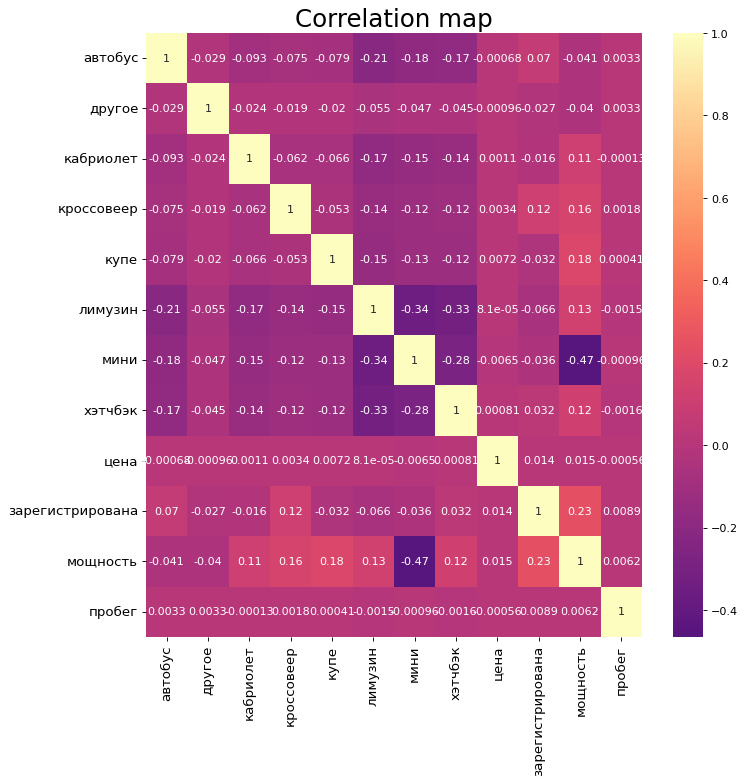

In [26]:
plt.figure(figsize=(10,10), dpi= 80)
sns.heatmap(car_df.corr(), xticklabels=car_df.corr().columns, yticklabels=car_df.corr().columns, cmap='magma', center=0, annot=True)


plt.title('Correlation map', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Делим выборку на обучающую и тестовую

In [27]:
x, y = car_df.drop(['цена'], axis=1), car_df['цена']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

## Обучаем модель

## Линейная регрессия без регуляризации

In [28]:
LR = LinearRegression()
LR.fit(x_train, y_train)
predict_LR = LR.predict(x_test)

person_PR, pvalue_pearson_PR = pearsonr(predict_LR, y_test)
spermen_PR, pvalue_spermen_PR = spearmanr(predict_LR, y_test)

In [29]:
print('Пирсон: ', person_PR)
print('pvalue: ', pvalue_pearson_PR)
print('Спирмен: ', spermen_PR)
print('pvalue: ', pvalue_spermen_PR)

Пирсон:  0.01338020612775808
pvalue:  0.0006042977051341188
Спирмен:  0.8238425975694339
pvalue:  0.0


In [30]:
print('Cредняя абсолютная ошибка = %8.5f' %mean_absolute_error(predict_LR, y_test))

Cредняя абсолютная ошибка = 7254.04276


## Lasso регрессия

In [36]:
lasso_for_GS = Lasso()

parameters = {
      "max_iter":[x for x in range(1, 300, 10)],
      "alpha":  np.linspace(0, 1, 20)[1:]}
lasso_GS = GridSearchCV(lasso_for_GS, parameters,  n_jobs = -1)
lasso_GS.fit(x_train, y_train)
best_alpha = lasso_GS.best_estimator_.alpha

print(lasso_GS.best_estimator_.alpha)
print(lasso_GS.best_estimator_.max_iter)

1.0
41


C:\Users\tealvl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e+15, tolerance: 1.046e+12
  model = cd_fast.enet_coordinate_descent(


In [37]:
lasso = Lasso(alpha=1, max_iter=41)
lasso.fit(x_train, y_train)
predict_lasso = lasso.predict(x_test)

C:\Users\tealvl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e+15, tolerance: 1.046e+12
  model = cd_fast.enet_coordinate_descent(


In [38]:
person_PR, pvalue_pearson_PR = pearsonr(predict_lasso, y_test)
spermen_PR, pvalue_spermen_PR = spearmanr(predict_lasso, y_test)

In [39]:
print('Пирсон: ', person_PR)
print('pvalue: ', pvalue_pearson_PR)
print('Спирмен: ', spermen_PR)
print('pvalue: ', pvalue_spermen_PR)

Пирсон:  0.013372870953811013
pvalue:  0.0006084986277604046
Спирмен:  0.8239336046553591
pvalue:  0.0


In [40]:
print('Cредняя абсолютная ошибка = %8.5f' %mean_absolute_error(predict_lasso, y_test))

Cредняя абсолютная ошибка = 7251.69517


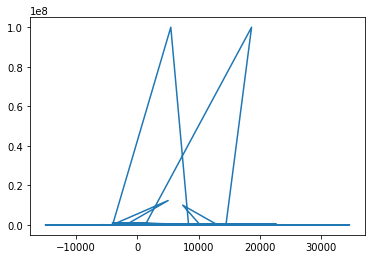

In [45]:
plt.plot(predict_lasso, y_test.va)

In [47]:
y_test

39158      2180
140116    14000
179541    16990
119275     2450
50227      6300
          ...  
104852     8000
142719     6900
59189     17000
24010      1150
96680      2400
Name: цена, Length: 65699, dtype: int64